In [1]:
import matplotlib.pyplot as plt

import tensorflow as tf 
from tensorflow import keras
import tensorflow_hub as hub

import numpy as np
import cv2

import os

import PIL.Image as Image

In [2]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

In [3]:
gold_fish = Image.open("shark.jpg").resize(IMAGE_SHAPE)

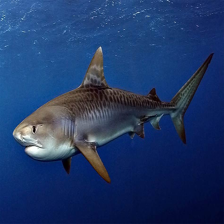

In [4]:
gold_fish

In [5]:
gold_fish = np.array(gold_fish)/255.0
gold_fish.shape

(224, 224, 3)

In [6]:
gold_fish[np.newaxis, ...].shape

(1, 224, 224, 3)

In [7]:
predict = classifier.predict(gold_fish[np.newaxis, ...])

1/1 [==============================] - 1s 1s/step


In [8]:
predicted_label = np.argmax(predict)

In [9]:
predicted_label

4

In [10]:
predict

array([[ 0.29378816,  1.5439517 ,  2.3240407 , ..., -0.81762105,
        -0.6075114 ,  0.29528677]], dtype=float32)

In [11]:
image_labels = []
with open("ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [12]:
image_labels[predicted_label]

'tiger shark'

## Load Flower Dataset

In [13]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

228813984/228813984 [==============================] - 55s 0us/step


In [21]:
data_dir

WindowsPath('datasets/flower_photos')

In [26]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('datasets/flower_photos')

In [27]:
list(data_dir.glob('*/*.jpg'))[:5]

[WindowsPath('datasets/flower_photos/daisy/100080576_f52e8ee070_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10140303196_b88d3d6cec.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172379554_b296050f82_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172567486_2748826a8b.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172636503_21bededa75_n.jpg')]

In [28]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [29]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[WindowsPath('datasets/flower_photos/roses/10090824183_d02c613f10_m.jpg'),
 WindowsPath('datasets/flower_photos/roses/102501987_3cdb8e5394_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/10503217854_e66a804309.jpg'),
 WindowsPath('datasets/flower_photos/roses/10894627425_ec76bbc757_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/110472418_87b6a3aa98_m.jpg')]

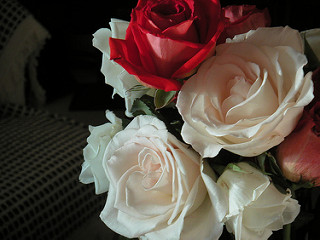

In [32]:
Image.open(str(roses[1]))

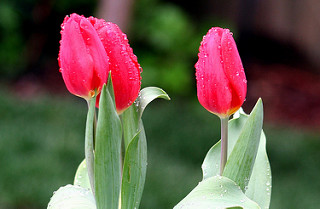

In [36]:
tulips = list(data_dir.glob('tulips/*'))
Image.open(str(tulips[0]))

## Read the flower images into numpy array using open cv

In [41]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [38]:
flower_labels = {
    "roses":0,
    "daisy":1,
    "dandelion":2,
    "sunflowers":3,
    "tulips":4,
}

In [55]:
str(flowers_images_dict["roses"][0])

'datasets\\flower_photos\\roses\\10090824183_d02c613f10_m.jpg'

In [50]:
img = cv2.imread(str(flowers_images_dict["roses"][0]))

In [53]:
img.shape

(240, 179, 3)

In [87]:
x=[]

y=[]

for flower,images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        x.append(resized_img)
        y.append(flower_labels[flower])      

In [88]:
x = np.array(x)
y= np.array(y)

## Train Test Split

In [89]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [90]:
x_train = x_train/255.0
x_test = x_test/255.0

In [91]:
x_train[0].shape

(224, 224, 3)

## Now take pre-trained model and retrain it using flowers images

In [92]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(feature_extractor_model,input_shape=(224,224,3),trainable = False)

In [93]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_3 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [172]:
model.compile(
    optimizer ="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

model.fit(x_train,y_train,epochs=10)

Epoch 1/10
92/92 [==============================] - 45s 460ms/step - loss: 0.2140 - accuracy: 0.9366
Epoch 2/10
92/92 [==============================] - 41s 451ms/step - loss: 0.1792 - accuracy: 0.9493
Epoch 3/10
92/92 [==============================] - 41s 450ms/step - loss: 0.1528 - accuracy: 0.9619
Epoch 4/10
92/92 [==============================] - 42s 452ms/step - loss: 0.1331 - accuracy: 0.9697
Epoch 5/10
92/92 [==============================] - 73s 795ms/step - loss: 0.1187 - accuracy: 0.9748
Epoch 6/10
92/92 [==============================] - 43s 472ms/step - loss: 0.1050 - accuracy: 0.9813
Epoch 7/10
92/92 [==============================] - 44s 480ms/step - loss: 0.0940 - accuracy: 0.9860
Epoch 8/10
92/92 [==============================] - 44s 482ms/step - loss: 0.0882 - accuracy: 0.9877
Epoch 9/10
92/92 [==============================] - 45s 488ms/step - loss: 0.0755 - accuracy: 0.9911
Epoch 10/10
92/92 [==============================] - 44s 481ms/step - loss: 0.0701 - accura

In [173]:
model.evaluate(x_test,y_test)

23/23 [==============================] - 12s 472ms/step - loss: 0.3440 - accuracy: 0.8787


[0.3440259099006653, 0.8787465691566467]

In [174]:
predicted = model.predict(x_test)

23/23 [==============================] - 13s 529ms/step


In [113]:
model_index = np.argmax(predicted[0])

In [175]:
predicted

array([[ -3.853652  , -11.654693  , -12.015647  ,  -8.347207  ,
         -8.456876  ],
       [ -8.049194  ,  -4.119339  ,  -3.495338  ,  -0.1525072 ,
         -8.930959  ],
       [-10.141675  , -12.316398  ,  -7.813679  , -11.623587  ,
          0.10466502],
       ...,
       [ -8.110503  ,  -1.2966772 ,  -3.5113473 ,  -4.063842  ,
         -5.7629776 ],
       [ -8.340732  ,  -4.1288724 ,   1.3518249 , -12.018319  ,
         -7.0919623 ],
       [ -7.161631  ,  -7.065175  ,  -4.1288342 ,  -9.141822  ,
         -5.266284  ]], dtype=float32)

In [176]:
labels=["roses",
        "daisy",
        "dandelion",
        "sunflowers",
        "tulips"]

In [177]:
model_predicted = [np.argmax(i) for i in predicted]

In [178]:
index = 7

In [179]:
labels[y_test[index]]

'roses'

In [180]:
labels[model_predicted[index]]

'roses'

In [181]:
cm = tf.math.confusion_matrix(labels=y_test,predictions=model_predicted)

Text(69.0, 0.5, 'Truth')

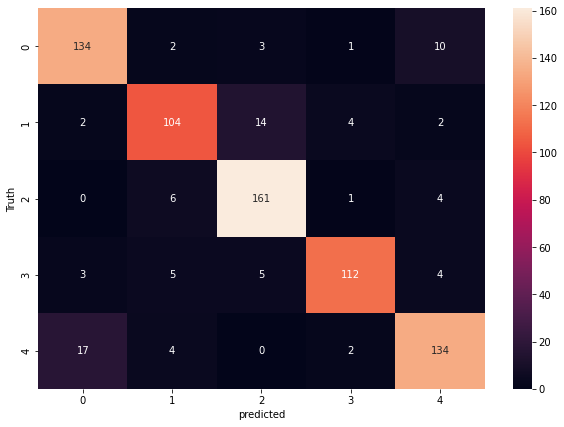

In [182]:
import seaborn as sns
plt.figure(figsize = (10,7))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('predicted')
plt.ylabel('Truth')


In [183]:
lion = Image.open("dandelions.jpg").resize(IMAGE_SHAPE)

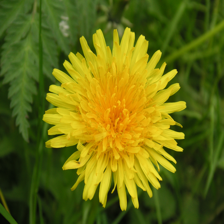

In [184]:
lion

In [185]:
lion =np.array(lion)/255

In [186]:
lion.shape

(224, 224, 3)

In [187]:
lion[np.newaxis,...].shape

(1, 224, 224, 3)

In [188]:
test = model.predict(lion[np.newaxis,...])

1/1 [==============================] - 0s 79ms/step


In [189]:
label_index = np.argmax(test)

In [190]:
labels[label_index]

'dandelion'